In [2]:
import re
import os
job_ids = [re.search('(\d){7}', dir).group() for dir in os.listdir("./shared/NORTH/") if re.search('data_(\d){7}', dir)]
job_ids.sort()

In [3]:
# The last (highest id) job id is the lates job
job_id = job_ids[-1]

In [4]:
job_id

'5145562'

In [5]:
import numpy as np
from matplotlib import pyplot as plt
from boutdata import collect
import matplotlib.cm as cm
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from boutdata.data import BoutData

path        = './shared/NORTH/data_' + job_id + '/'
bdata = BoutData(path)
outputs = bdata['outputs']
options  =bdata['options']

field_keys = bdata['outputs'].keys()


/home/niflheim/s173965/.local/lib/python3.9/site-packages/boutdata/data.py:732: AlwaysWarning: While building x, y, z coordinate arrays, an exception occured: name 'mxg' is not defined
Evaluating non-scalar options not available
  alwayswarn(


In [6]:
from matplotlib import rcParams
rcParams.update({
    "font.size": 16})
rcParams['axes.titlepad'] = 20

## Read Options

In [7]:
def get_option(*keys):
    from numpy import sqrt
    val = options
    try:
        for key in keys:
            val = val[key]
        return eval(str(val))
    except:
        print('Error reading option for keys: ', keys)
        return 0

def get_options(keys_list):
    vals = []
    for keys in keys_list:
        vals.append(get_option(*keys))
    return vals

In [8]:
R, Te0, N_nuclei, mp, B0, e, mxg, myg = get_options([
    ('north', 'R'), ('north', 'Te0'), ('north', 'N_nuclei'),
    ('north', 'mp'), ('north', 'B0'), ('north', 'e'),
    (['mxg']), (['myg'])])
R, Te0, N_nuclei, mp, B0, e, mxg, myg

(0.25, 10.0, 2, 1.67e-27, 0.077, 1.6e-19, 2, 0)

In [9]:
print('nx: ', options['mesh']['nx'])
print('ny: ', options['mesh']['ny'])
print('nz: ', options['mesh']['nz'])
print('Lx: ', options['mesh']['Lx'])
print('rho_s: ', options['north']['rho_s'])
print('oci: ', options['north']['oci'])

nx:  80+2*mxg
ny:  1
nz:  256
Lx:  north:a/north:rho_s
rho_s:  sqrt(2*e*Te0/(N_nuclei*mp))/oci
oci:  e*B0/(N_nuclei*mp)


In [10]:
nx_all, ny_all, nz_all = get_options([('mesh', 'nx'),('mesh', 'ny'),('mesh', 'nz')])
oci = get_option('north', 'oci')
rho_s = get_option('north', 'rho_s')
Lx = R/rho_s * rho_s
nx_inner = nx_all - 2*mxg
ny_inner = ny_all - 2*myg
nz_inner = nz_all

In [11]:
#%% Read data

field_list  = ['T', 'n', 'phi', 'vort','source_n', 'source_T','wall_shadow']
par_list    = ['t_array']
# fast_list   = ['t_array', 'n0', 'phi0', 'n1', 'phi1', 'n2', 'phi2', 'T0', 'T1', 'T2']
#%%
data, par, fast = {}, {}, {}

for _field in field_list:
    data[_field] = collect(_field, path = path, xguards = False)

for _par in par_list:
    par[_par] = collect(_par, path = path, xguards = False)

mxsub = 2 mysub = 1 mz = 256

nxpe = 40, nype = 1, npes = 40

Reading from 0: [2-3][0-0] -> [0-1][0-0]

Reading from 1: [2-3][0-0] -> [2-3][0-0]

Reading from 2: [2-3][0-0] -> [4-5][0-0]

Reading from 3: [2-3][0-0] -> [6-7][0-0]

Reading from 4: [2-3][0-0] -> [8-9][0-0]

Reading from 5: [2-3][0-0] -> [10-11][0-0]

Reading from 6: [2-3][0-0] -> [12-13][0-0]

Reading from 7: [2-3][0-0] -> [14-15][0-0]

Reading from 8: [2-3][0-0] -> [16-17][0-0]

Reading from 9: [2-3][0-0] -> [18-19][0-0]

Reading from 10: [2-3][0-0] -> [20-21][0-0]

Reading from 11: [2-3][0-0] -> [22-23][0-0]

Reading from 12: [2-3][0-0] -> [24-25][0-0]

Reading from 13: [2-3][0-0] -> [26-27][0-0]

Reading from 14: [2-3][0-0] -> [28-29][0-0]

Reading from 15: [2-3][0-0] -> [30-31][0-0]

Reading from 16: [2-3][0-0] -> [32-33][0-0]

Reading from 17: [2-3][0-0] -> [34-35][0-0]

Reading from 18: [2-3][0-0] -> [36-37][0-0]

Reading from 19: [2-3][0-0] -> [38-39][0-0]

Reading from 20: [2-3][0-0] -> [40-41][0-0]

Reading from 

In [12]:
dmp_nr = 4

thetas = np.linspace(0, 2 * np.pi, nz_inner)
rhos = np.linspace(1/(2*nx_inner), Lx+1/(2*nx_inner), nx_inner)

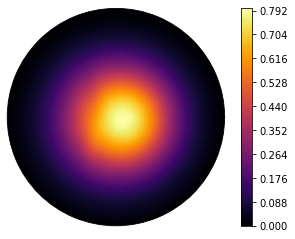

In [13]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

plot0 = ax.contourf(thetas, rhos, data['n'][dmp_nr, :, :, :].squeeze(), 100, cmap = 'inferno')
ax.set_rticks([])
ax.set_xticks([])
plt.colorbar(plot0, ax=ax)

In [14]:
# fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# plot0 = ax.contourf(thetas, rhos, data['n_source'][:, :, :].squeeze(), 100, cmap = 'inferno')
# plt.colorbar(plot0, ax=ax)

In [15]:
vmax = data['n'][data['n'].shape[0]-1, :, :, :].max()

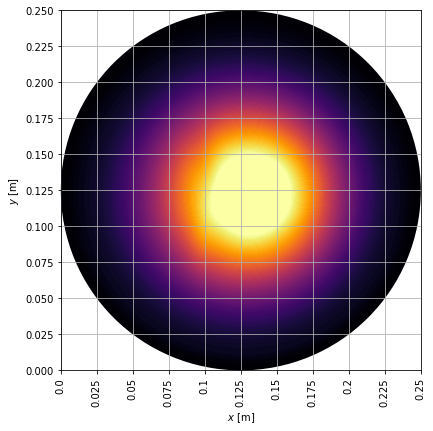

In [16]:
def plot_cyl_data(data, cbarlabel):
    fig = plt.figure(figsize=(5,5))

    # the carthesian axis:
    rect = [0, 0, 1, 1]
    ax_carthesian  = fig.add_axes(rect,zorder=2)
    ax_carthesian.patch.set_alpha(0)
    ax_polar = fig.add_axes(rect, polar=True, frameon=False,zorder=1)

    # the polar axis:
    contour_set = ax_polar.contourf(thetas, rhos, data, 100, cmap = 'inferno', vmin=0, vmax=vmax)
    ax_polar.grid(False)
    ax_polar.set_xticks([])
    ax_polar.set_rticks([])
    # im_ratio = data.shape[1]/data.shape[0]
    # # plt.colorbar(label=cbarlabel,fraction=0.046*im_ratio, pad=0.04)
    # plt.colorbar(contour_set, ax=ax_polar, label=cbarlabel, fraction=0.046*im_ratio, pad=0.04)
    # plt.colorbar(contour_set, ax=ax_carthesian, label=cbarlabel, fraction=0.046*im_ratio, pad=0.04, alpha=0)

    ticks = np.round(np.linspace(0,Lx,11),3)
    ax_carthesian.set_xlim(0,Lx)
    ax_carthesian.set_ylim(0,Lx)
    ax_carthesian.set_xticks(ticks)
    ax_carthesian.set_yticks(ticks)
    ax_carthesian.set_xticklabels(ticks,rotation = 90)
    ax_carthesian.set_xlabel(r'$x$ [m]')
    ax_carthesian.set_ylabel(r'$y$ [m]')
    ax_carthesian.grid()

plot_cyl_data(data['n'][dmp_nr, :, :, :].squeeze(), cbarlabel=r'$n \,\, [\mathrm{m^{-3}}]$')

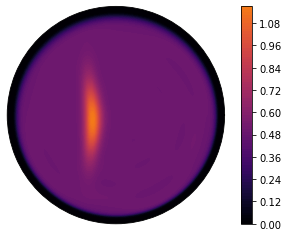

In [17]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

plot0 = ax.contourf(thetas, rhos, data['T'][dmp_nr, :, :, :].squeeze(), 100, cmap = 'inferno', vmin=0,vmax=data['T'].max())
ax.set_rticks([])
ax.set_xticks([])
plt.colorbar(plot0, ax=ax)

In [18]:
# Method to change the contour data points
def plot_field(field, i, cmap='inferno'):
    vmin = data[field].min()
    vmax = data[field].max()
    # ax.clear()
    contour_set = ax.contourf(thetas, rhos, data[field][i, :, :, :].squeeze(), 100, cmap = cmap, vmin=vmin, vmax=vmax)
    ax.set_rticks([])
    ax.set_xticks([])
    fig.tight_layout()
    return contour_set

def animate_n(i):
    plot_field('n',i)
def animate_T(i):
    plot_field('T',i)
def animate_vort(i):
    plot_field('vort',i, cmap='jet')

In [19]:
# Call animate method
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

plt.colorbar(plot_field('n',0), ax=ax)
ani = animation.FuncAnimation(fig, animate_n, frames=data['n'].shape[0], interval=100, blit=False)
ani.save('plots/' + job_id + '_animation_n.gif', fps = 4)
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


MovieWriter ffmpeg unavailable; using Pillow instead.


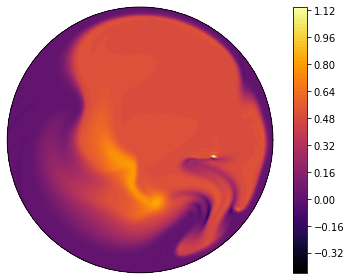

In [ ]:
# Call animate method
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

plt.colorbar(plot_field('T',-1), ax=ax)
ani = animation.FuncAnimation(fig, animate_T, frames=data['T'].shape[0], interval=100, blit=False)
ani.save('plots/' + job_id + 'animation_T.gif', fps = 4)
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


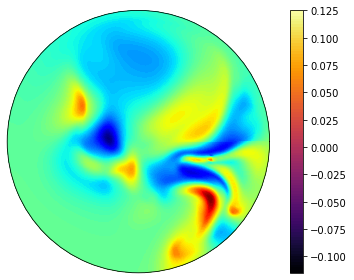

In [ ]:
# Call animate method
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

plt.colorbar(plot_field('vort',-1), ax=ax)
ani = animation.FuncAnimation(fig, animate_vort, frames=data['vort'].shape[0], interval=100, blit=False)
ani.save('plots/' + job_id + 'animation_vort.gif', fps = 4)
plt.show()